# DCGAN
In this notebook, I have implemented a conditional DCGAN. Before training my GAN model, I have trained an autoencoder to extract features of input images. After that, I used a convolutional network to generate image from input features and noise. For the discriminator, I have used convolutional networks too.

# Load the dataset

Load the MNIST dataset bellow. You can use either `torchvision.datasets.MNIST` or `sklearn.datasets.fetch_openml()` or any other way to load the dataset.

In [1]:
import numpy as np
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F

In [2]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.4),
    transforms.RandomRotation(degrees=(0, 20)),
    transforms.ToTensor()])

In [3]:
train_set = datasets.MNIST(root='data', train=True, download=True, 
                           transform=transform)

test_set = datasets.MNIST(root='data', train=False, download=True, 
                          transform=transforms.ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Design model

Our GAN is supposed to construct the right half of an image given the left half of it and a noise. The general structure of this GAN is shown below.

![](https://github.com/AIMed-Team/edu-content/blob/master/notebooks/learning-tasks/6_cgan/images/CGAN.jpeg?raw=1)

In [5]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, 3),                       
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Conv2d(8, 32, 3),                    
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(3, stride=2, padding=1),    
            nn.Dropout(p=0.4),
            nn.Conv2d(32, 128, 3, padding=1),           
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 3, padding=1),  
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(3, stride=2, padding=1),
            nn.Dropout(p=0.4),
            nn.Conv2d(128, 256, 3, padding=1),    
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.AvgPool2d(3, stride=2, padding=1), 
            nn.Dropout(p=0.4)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3, stride=2),  
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128, 64, 3, stride=1),   
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 16, 3, stride=1),   
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.ConvTranspose2d(16, 8, 3, stride=2),     
            nn.ReLU(),
            nn.ConvTranspose2d(8, 4, 4, stride=1),  
            nn.ReLU(),
            nn.ConvTranspose2d(4, 1, 3, stride=1),     
            nn.Sigmoid()
        )

    def forward(self, images):
        x = self.encoder(images)
        y = self.decoder(x)
        return y

    def encode(self, images):
        return self.encoder(images)

In [6]:
class Generator(nn.Module):
    def __init__(self, autoencoder, noise_len):
        super().__init__()
        self.autoencoder = autoencoder
        self.noise_len = noise_len

        self.layers = nn.Sequential(                                   
            nn.ConvTranspose2d(256+self.noise_len, 128, 3, stride=1),              
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128, 64, 3, stride=1),                      
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 16, 3, stride=1),                       
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.ConvTranspose2d(16, 8, 3, stride=1),                       
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.ConvTranspose2d(8, 4, 3, stride=(2, 1), padding=(0, 1)),   
            nn.ReLU(),
            nn.BatchNorm2d(4),
            nn.ConvTranspose2d(4, 2, 3, stride=1),                       
            nn.ReLU(),
            nn.BatchNorm2d(2),
            nn.ConvTranspose2d(2, 1, (4, 3), stride=1),   
            nn.Sigmoid()
        )

    def forward(self, noise, input):    
        output = torch.cat((self.autoencoder.encode(input), noise), dim=1)        
        output = self.layers(output)              
        return output

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(                          
            nn.Conv2d(1, 8, 3, padding=1),                  
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(8),
            nn.MaxPool2d(3, stride=2, padding=1),          
            nn.Dropout(p=0.4),
            nn.Conv2d(8, 32, 3, padding=1),               
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(3, stride=2, padding=1),    
            nn.Dropout(p=0.4),
            nn.Conv2d(32, 64, 3, padding=1),         
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(3, stride=2, padding=1),           
            nn.Dropout(p=0.4),
            nn.Conv2d(64, 128, 3, padding=1),     
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(128),
            nn.AvgPool2d(3, stride=2, padding=1),         
            nn.Dropout(p=0.4),
            nn.Flatten(),                                 
            nn.Linear(512, 1),
            nn.Sigmoid()           
        )

    def forward(self, images):
        return self.conv(images)

# Train AutoEncoder

In [8]:
batch_size = 32
lr = 0.0001
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

In [9]:
autoencoder = AutoEncoder().to(device)
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=lr)

losses = []
best_loss = 1e9

In [10]:
number_of_epochs = 10

for epoch in range(number_of_epochs):
    total_loss = 0
    n = 0
    for images, labels in train_loader:
      optimizer.zero_grad()
      images = images.to(device)
      
      batch_size = images.shape[0]
      n += batch_size

      loss = criterion(autoencoder(images), images)
      total_loss += loss.item() * batch_size

      loss.backward()
      optimizer.step()

    total_loss /= n
    print('epoch ' + str(epoch) + ", loss: " + str(total_loss))  
    print()  
    
    losses.append(total_loss)

    if total_loss < best_loss:
        best_loss = total_loss
        torch.save(autoencoder.state_dict(), 'autoencoder.pickle')


epoch 0, loss: 0.06156054207384586

epoch 1, loss: 0.015274961219231288

epoch 2, loss: 0.012436571067074935

epoch 3, loss: 0.011175439914564291

epoch 4, loss: 0.010347881715993086

epoch 5, loss: 0.009758343318849802

epoch 6, loss: 0.009307901464899382

epoch 7, loss: 0.008963160124172767

epoch 8, loss: 0.008661682965606451

epoch 9, loss: 0.008415542931854725



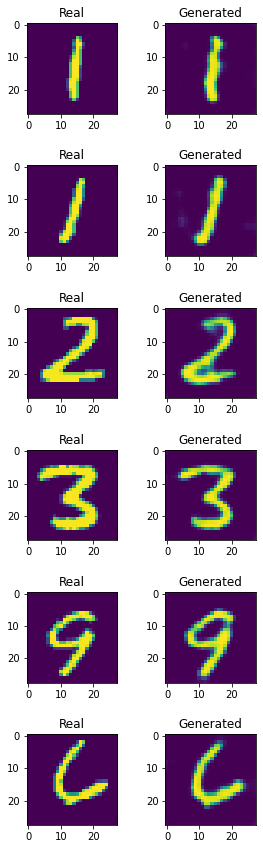

In [11]:
fig, axs = plt.subplots(6, 2, figsize=(4, 2 * 6))
fig.tight_layout()
indices = np.random.choice(range(len(test_set)), size=6)

with torch.no_grad():
    for i in range(6):
        img, _ = test_set[indices[i]]
        input = img.unsqueeze(0).to(device)
        output = autoencoder(input)
        axs[i, 0].imshow(transforms.ToPILImage()(input[0]))
        axs[i, 1].imshow(transforms.ToPILImage()(output[0]))
        axs[i, 0].set_title('Real')
        axs[i, 1].set_title('Generated')

plt.show()

# Train GAN


In [12]:
batch_size = 32
lr = 0.0001
noise_len = 100

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

In [13]:
auto_encoder = AutoEncoder()
auto_encoder.load_state_dict(torch.load('autoencoder.pickle'))

for param in auto_encoder.parameters():
    param.requires_grad = False

generator = Generator(auto_encoder, noise_len).to(device)
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)

discriminator = Discriminator().to(device)
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr)

criterion = nn.BCELoss().to(device)

In [14]:
generator_l = []
discriminator_l = []
best_loss = 1e9

number_of_epochs = 25

for epoch in range(1, number_of_epochs + 1):
    generator_total_loss = 0
    discriminator_total_loss = 0
    generator_num_samples = 0
    discriminator_num_samples = 0
    for i, (images, _) in enumerate(train_loader):
        images = images.to(device)
        batch_size = images.shape[0]
        valid = torch.full((batch_size, 1), 1.0).to(device)
        half_images = images[..., :14]
        y = torch.randn([batch_size, noise_len, 3, 2]).to(device)

        if i % 5 != 0:
            generator_num_samples += batch_size
            generator.train()
            generator_optimizer.zero_grad()

            generator_output = generator(y, half_images)
            generator_images = torch.cat((half_images, generator_output), dim=-1)
            validation = discriminator(generator_images)
            generator_loss = criterion(validation, valid)
            generator_total_loss += generator_loss.item() * batch_size
            generator_loss.backward()
            generator_optimizer.step()

        else:
            discriminator_num_samples += batch_size
            discriminator.train()
            discriminator_optimizer.zero_grad()
            generator_images = None
            with torch.no_grad():
                generator_output = generator(y, half_images)
                generator_images = torch.cat((half_images, generator_output),
                dim=-1)

            discriminator_input = torch.cat((images, generator_images.detach()),
                                            dim=0)
            discriminator_label = torch.cat((valid, 1-valid), dim=0)
            discriminator_loss = criterion(discriminator(discriminator_input), 
                                           discriminator_label)
            discriminator_total_loss += discriminator_loss.item() * 2 * batch_size
            discriminator_loss.backward()
            discriminator_optimizer.step()

    try:
        print('epoch ' + str(epoch) + ", generator loss: " + 
              str(generator_total_loss / generator_num_samples) +
              ', discriminator loss: ' +
              str(discriminator_total_loss / (2 * discriminator_num_samples)))  
        print()  
    except:
        pass


    generator_total_loss /= generator_num_samples
    discriminator_total_loss /= 2 * discriminator_num_samples
    generator_l.append(generator_total_loss)
    discriminator_l.append(discriminator_total_loss)

    if generator_total_loss < best_loss:
        best_loss = generator_total_loss
        torch.save(generator.state_dict(), 'generator.pickle')
        torch.save(discriminator.state_dict(), 'discriminator.pickle')

epoch 1, generator loss: 1.0983340709209441, discriminator loss: 0.11432932954281569

epoch 2, generator loss: 1.4843224309682845, discriminator loss: 0.1187570056244731

epoch 3, generator loss: 1.402161164164543, discriminator loss: 0.21714885675907136

epoch 4, generator loss: 1.1356509211262067, discriminator loss: 0.39898615185419717

epoch 5, generator loss: 1.0888342321316402, discriminator loss: 0.2992564676006635

epoch 6, generator loss: 1.1123444191614786, discriminator loss: 0.35354820064703624

epoch 7, generator loss: 0.9745214416583379, discriminator loss: 0.4600032421350479

epoch 8, generator loss: 1.1613224603732426, discriminator loss: 0.2571448109944661

epoch 9, generator loss: 1.0978962121407192, discriminator loss: 0.3027930583357811

epoch 10, generator loss: 0.9422137970924378, discriminator loss: 0.3979867664972941

epoch 11, generator loss: 1.0221879089275996, discriminator loss: 0.3564585389693578

epoch 12, generator loss: 1.0136631036599477, discriminator 

# Plot Generator/Discriminator losses

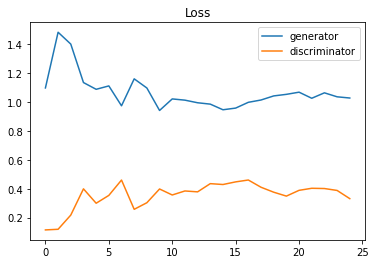

In [15]:
fig, ax = plt.subplots(1, 1)

ax.plot(generator_l, label='generator')
ax.plot(discriminator_l, label='discriminator')
ax.set_title('Loss')

plt.legend()
plt.show()

# Draw examples

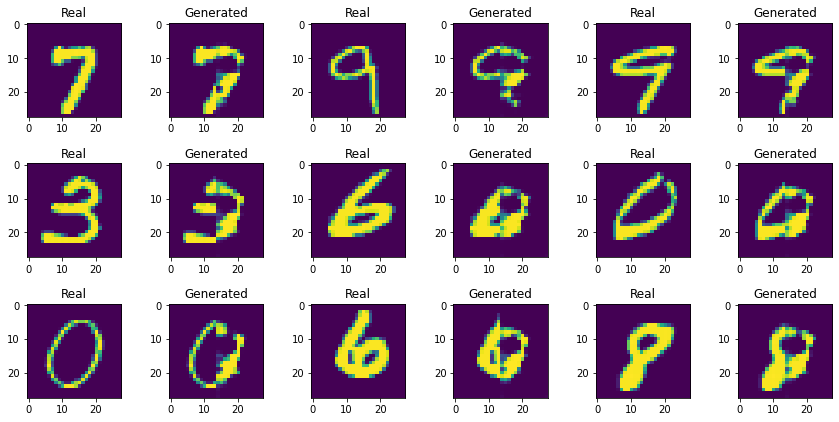

In [19]:
row_num = 3
col_num = 3
n = row_num * col_num
indices = np.random.choice(range(len(test_set)), size=n)
transform = transforms.ToPILImage()

fig, axs = plt.subplots(row_num, 2 * col_num, figsize=(2 * 2 * col_num,
                                                       2 * row_num))
fig.tight_layout()

with torch.no_grad():
    for k in range(n):
        img, label = test_set[indices[k]]

        half_image = img[..., :14].unsqueeze(0).to(device)

        output = generator(torch.randn([1, noise_len, 3, 2]).to(device),
                           half_image)
        generated_output = torch.cat((half_image, output), dim=-1)

        i = k // col_num
        j = 2 * (k % col_num)
        axs[i, j].imshow(transform(img[0]))
        axs[i, j+1].imshow(transform(generated_output[0]))
        axs[i, j].set_title('Real')
        axs[i, j+1].set_title('Generated')

plt.show()